In [ ]:
!pip install torch datasets matplotlib tqdm sacrebleu tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
# Step 2: Import required modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import os
from sacrebleu import corpus_bleu
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [ ]:
# Step 3: Load dataset (English-Nepali)
data = load_dataset("CohleM/english-to-nepali")
eng_data = data['train']['en']
nep_data = data['train']['ne']


In [ ]:
# Step 4: Train and Save BPE Tokenizers
with open("english.txt", "w") as f:
    f.write("\n".join(eng_data))
with open("nepali.txt", "w") as f:
    f.write("\n".join(nep_data))

eng_tokenizer = Tokenizer(models.BPE())
trainer = trainers.BpeTrainer(vocab_size=50000, special_tokens=["<pad>", "<s>", "</s>"])
eng_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
eng_tokenizer.train(["english.txt"], trainer)
eng_tokenizer.save("eng_tokenizer_50k.json")

nep_tokenizer = Tokenizer(models.BPE())
nep_tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
nep_tokenizer.train(["nepali.txt"], trainer)
nep_tokenizer.save("nep_tokenizer_50k.json")

In [ ]:
# Step 5: Load BPE tokenizers
eng_tok = Tokenizer.from_file("eng_tokenizer_50k.json")
nep_tok = Tokenizer.from_file("nep_tokenizer_50k.json")

PAD_ID = 1500
SOS_ID = 1501
EOS_ID = 1502

In [ ]:
# Step 6: Tokenize and prepare training data
def encode_ids(tokenizer, text):
    return tokenizer.encode(text).ids

enco_eng_data = []
for i, s in enumerate(eng_data):
    ids = eng_tok.encode(s).ids
    if isinstance(ids, int):
        print(f"❌ Error at index {i}: {s} → {ids}")
    assert isinstance(ids, list), f"ENG {i} is not a list: {ids}"
    enco_eng_data.append(ids)

deco_nep_data_sos = []
for i, s in enumerate(nep_data):
    ids = nep_tok.encode(s).ids
    full = [SOS_ID] + ids
    assert isinstance(full, list), f"SOS {i} not list: {full}"
    deco_nep_data_sos.append(full)

deco_nep_data_eos = []
for i, s in enumerate(nep_data):
    ids = nep_tok.encode(s).ids
    if isinstance(ids, int):
        print(f"❌ At index {i}: Nepali '{s}' → got int instead of list: {ids}")
        ids = [ids]  # force wrap it in list to avoid crash
    assert isinstance(ids, list), f"❌ Expected list, got {type(ids)}"
    deco_nep_data_eos.append(ids + [EOS_ID])

# Deep check of your tokenized training data
for i in range(5):
    print(f"--- Index {i} ---")
    print("enco_eng_data:", enco_eng_data[i], "|", type(enco_eng_data[i]))
    print("deco_nep_data_sos:", deco_nep_data_sos[i], "|", type(deco_nep_data_sos[i]))
    print("deco_nep_data_eos:", deco_nep_data_eos[i], "|", type(deco_nep_data_eos[i]))

print("🔎 Verifying each data point before DataLoader...")
for i in range(len(enco_eng_data)):
    x, y, z = enco_eng_data[i], deco_nep_data_sos[i], deco_nep_data_eos[i]

    if isinstance(x, int):
        print(f"❌ enco_eng_data[{i}] is int: {x}")
    if isinstance(y, int):
        print(f"❌ deco_nep_data_sos[{i}] is int: {y}")
    if isinstance(z, int):
        print(f"❌ deco_nep_data_eos[{i}] is int: {z}")

    if not isinstance(x, list):
        print(f"❌ enco_eng_data[{i}] is not list: {x}")
    if not isinstance(y, list):
        print(f"❌ deco_nep_data_sos[{i}] is not list: {y}")
    if not isinstance(z, list):
        print(f"❌ deco_nep_data_eos[{i}] is not list: {z}")

    for tok in x:
        if not isinstance(tok, int):
            print(f"❌ Non-int token in enco_eng_data[{i}]: {tok}")
    for tok in y:
        if not isinstance(tok, int):
            print(f"❌ Non-int token in deco_nep_data_sos[{i}]: {tok}")
    for tok in z:
        if not isinstance(tok, int):
            print(f"❌ Non-int token in deco_nep_data_eos[{i}]: {tok}")



--- Index 0 ---
enco_eng_data: [5446, 4095, 481, 412, 4364, 397, 1135, 6002, 16] | <class 'list'>
deco_nep_data_sos: [1501, 1149, 1434, 1161, 16996, 10, 24269, 11, 32363, 663, 1665, 3693] | <class 'list'>
deco_nep_data_eos: [1149, 1434, 1161, 16996, 10, 24269, 11, 32363, 663, 1665, 3693, 1502] | <class 'list'>
--- Index 1 ---
enco_eng_data: [961, 7529, 13372, 481, 4163, 400, 14391, 385, 29793, 1044, 854, 3220, 418, 4901, 1279, 397, 546, 454, 1892, 394, 2008, 390, 2992, 2656, 400, 8117, 5089, 397, 4307, 3898, 386, 1966, 239, 3994, 911, 3389, 14, 2051, 390, 31856, 394, 1374, 16] | <class 'list'>
deco_nep_data_sos: [1501, 774, 4260, 32363, 10, 612, 4814, 11, 595, 35113, 767, 1161, 3701, 6333, 2164, 14, 2279, 14, 790, 14, 1569, 687, 4260, 266, 1679, 897, 689, 1440, 6569, 8597, 1892, 23803, 15879, 7022, 7719, 815, 823, 2955, 2586, 2778, 4979, 1098] | <class 'list'>
deco_nep_data_eos: [774, 4260, 32363, 10, 612, 4814, 11, 595, 35113, 767, 1161, 3701, 6333, 2164, 14, 2279, 14, 790, 14, 1569, 

In [ ]:
# Step 7: Dataset & DataLoader
class TranslationDataset(Dataset):
    def __init__(self, input_data, target_data, output_data):
        self.input_data = input_data
        self.target_data = target_data
        self.output_data = output_data

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        return self.input_data[idx], self.target_data[idx], self.output_data[idx]

def pad_batch(batch):
    input_seqs, target_seqs, output_seqs = zip(*batch)

    def validate(group, name):
        for i, seq in enumerate(group):
            if isinstance(seq, int):
                raise TypeError(f"❌ {name}[{i}] is an int instead of list: {seq}")
            if not isinstance(seq, list):
                raise TypeError(f"❌ {name}[{i}] is not list: {type(seq)} -> {seq}")
            for j, tok in enumerate(seq):
                if not isinstance(tok, int):
                    raise TypeError(f"❌ {name}[{i}][{j}] is not int: {type(tok)} -> {tok}")

    validate(input_seqs, "input_seqs")
    validate(target_seqs, "target_seqs")
    validate(output_seqs, "output_seqs")

    max_len = max(len(seq) for seq in input_seqs + target_seqs + output_seqs)
    pad_tensor = lambda seq: seq + [PAD_ID] * (max_len - len(seq))

    try:
        return (
            torch.tensor([pad_tensor(s) for s in input_seqs]),
            torch.tensor([pad_tensor(s) for s in target_seqs]),
            torch.tensor([pad_tensor(s) for s in output_seqs])
        )
    except Exception as e:
        print("⚠️ ERROR DURING TENSOR CONVERSION:")
        print("Sample input_seqs:", input_seqs[:3])
        print("Sample target_seqs:", target_seqs[:3])
        print("Sample output_seqs:", output_seqs[:3])
        raise e



dataset = TranslationDataset(enco_eng_data, deco_nep_data_sos, deco_nep_data_eos)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=pad_batch)
for i in range(5):
    print(f"Checking sample {i}")
    x, y, z = enco_eng_data[i], deco_nep_data_sos[i], deco_nep_data_eos[i]
    print(f"ENG: {x} ({type(x)}), NEP-SOS: {y} ({type(y)}), NEP-EOS: {z} ({type(z)})")
    for t in [x, y, z]:
        assert isinstance(t, list), f"❌ Not list: {t}"
        for token in t:
            assert isinstance(token, int), f"❌ Not int: {token} in {t}"
print("🔍 Testing DataLoader batching...")
for batch_idx, (src, tgt, out) in enumerate(train_loader):
    print(f"✅ Batch {batch_idx+1}")
    print(" - Input shape :", src.shape)
    print(" - Target shape:", tgt.shape)
    print(" - Output shape:", out.shape)
    break  # Just check the first batch


Checking sample 0
ENG: [5446, 4095, 481, 412, 4364, 397, 1135, 6002, 16] (<class 'list'>), NEP-SOS: [1501, 1149, 1434, 1161, 16996, 10, 24269, 11, 32363, 663, 1665, 3693] (<class 'list'>), NEP-EOS: [1149, 1434, 1161, 16996, 10, 24269, 11, 32363, 663, 1665, 3693, 1502] (<class 'list'>)
Checking sample 1
ENG: [961, 7529, 13372, 481, 4163, 400, 14391, 385, 29793, 1044, 854, 3220, 418, 4901, 1279, 397, 546, 454, 1892, 394, 2008, 390, 2992, 2656, 400, 8117, 5089, 397, 4307, 3898, 386, 1966, 239, 3994, 911, 3389, 14, 2051, 390, 31856, 394, 1374, 16] (<class 'list'>), NEP-SOS: [1501, 774, 4260, 32363, 10, 612, 4814, 11, 595, 35113, 767, 1161, 3701, 6333, 2164, 14, 2279, 14, 790, 14, 1569, 687, 4260, 266, 1679, 897, 689, 1440, 6569, 8597, 1892, 23803, 15879, 7022, 7719, 815, 823, 2955, 2586, 2778, 4979, 1098] (<class 'list'>), NEP-EOS: [774, 4260, 32363, 10, 612, 4814, 11, 595, 35113, 767, 1161, 3701, 6333, 2164, 14, 2279, 14, 790, 14, 1569, 687, 4260, 266, 1679, 897, 689, 1440, 6569, 8597, 18

In [ ]:
# Step 8: Transformer Model
class EncoderBlock(nn.Module):
    def __init__(self, embd, heads, dropout):
        super().__init__()
        self.attn = nn.MultiheadAttention(embd, heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embd, 2048),
            nn.ReLU(),
            nn.Linear(2048, embd)
        )
        self.norm1 = nn.LayerNorm(embd)
        self.norm2 = nn.LayerNorm(embd)

    def forward(self, x):
        attn_out, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_out)
        ff_out = self.ff(x)
        return self.norm2(x + ff_out)

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, embd, heads, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embd, heads, dropout=dropout, batch_first=True)
        self.cross_attn = nn.MultiheadAttention(embd, heads, dropout=dropout, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embd, 2048),
            nn.ReLU(),
            nn.Linear(2048, embd)
        )
        self.norm1 = nn.LayerNorm(embd)
        self.norm2 = nn.LayerNorm(embd)
        self.norm3 = nn.LayerNorm(embd)

    def forward(self, x, enc_out):
        self_attn_out, _ = self.self_attn(x, x, x, attn_mask=torch.triu(torch.ones(x.size(1), x.size(1)) * float('-inf'), diagonal=1).to(x.device))
        x = self.norm1(x + self_attn_out)
        cross_attn_out, _ = self.cross_attn(x, enc_out, enc_out)
        x = self.norm2(x + cross_attn_out)
        ff_out = self.ff(x)
        return self.norm3(x + ff_out)


In [ ]:
class TranslationModel(nn.Module):
    def __init__(self, vocab_size, embd, heads, layers, dropout):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embd)
        self.pe = nn.Embedding(500, embd)
        self.encoder = nn.Sequential(*[EncoderBlock(embd, heads, dropout) for _ in range(layers)])
        self.decoder = nn.ModuleList([DecoderBlock(embd, heads, dropout) for _ in range(layers)])
        self.ln = nn.LayerNorm(embd)
        self.out = nn.Linear(embd, vocab_size)

    def forward(self, src, tgt):
        seq_len = src.size(1)
        pos = torch.arange(seq_len, device=src.device).unsqueeze(0)
        src = self.embed(src) + self.pe(pos)
        enc_out = self.encoder(src)

        tgt_len = tgt.size(1)
        pos_t = torch.arange(tgt_len, device=src.device).unsqueeze(0)
        tgt = self.embed(tgt) + self.pe(pos_t)
        for layer in self.decoder:
            tgt = layer(tgt, enc_out)

        return self.out(self.ln(tgt))

In [ ]:
device = torch.device("cpu")  # or 'cuda' if available
model = TranslationModel(vocab_size=50000, embd=256, heads=8, layers=4, dropout=0.1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(ignore_index=PAD_ID)

train_loss = []
for epoch in range(5):
    model.train()
    total_loss = 0
    for src, tgt, out in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        src, tgt, out = src.to(device), tgt.to(device), out.to(device)
        logits = model(src, tgt)
        loss = loss_fn(logits.view(-1, logits.size(-1)), out.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg = total_loss / len(train_loader)
    train_loss.append(avg)
    print(f"Epoch {epoch+1}, Loss: {avg:.4f}")
    torch.save(model.state_dict(), f"transformer_epoch{epoch+1}.pth")


Epoch 1:   1%|▏         | 158/11084 [04:12<4:50:49,  1.60s/it] 


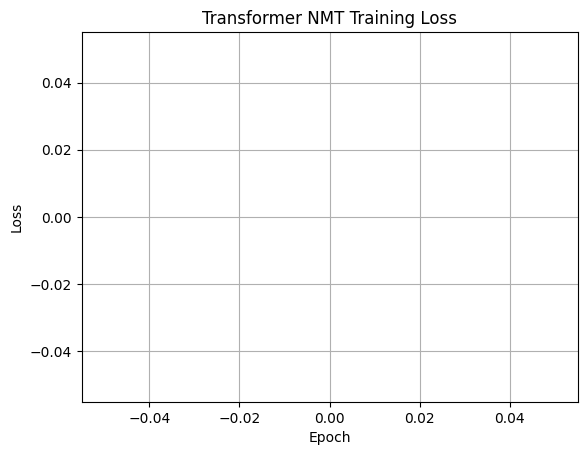

In [ ]:

# Step 10: Plot Loss
plt.plot(train_loss, marker='o')
plt.title("Transformer NMT Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# Step 11: Translation function
def translate(sentence, max_len=30):
    model.eval()
    with torch.no_grad():
        input_ids = torch.tensor([encode_ids(eng_tok, sentence)]).to('cuda')
        pos = torch.arange(input_ids.size(1), device='cuda').unsqueeze(0)
        enc_out = model.encoder(model.embed(input_ids) + model.pe(pos))

        tgt_ids = torch.tensor([[SOS_ID]]).to('cuda')
        for _ in range(max_len):
            pos_t = torch.arange(tgt_ids.size(1), device='cuda').unsqueeze(0)
            x = model.embed(tgt_ids) + model.pe(pos_t)
            for layer in model.decoder:
                x = layer(x, enc_out)
            output = model.out(model.ln(x))
            next_token = output[:, -1, :].argmax(dim=-1)
            tgt_ids = torch.cat([tgt_ids, next_token.unsqueeze(1)], dim=1)
            if next_token.item() == EOS_ID:
                break
        return nep_tok.decode(tgt_ids[0, 1:-1].tolist())

In [ ]:
# Step 12: Evaluate with BLEU
preds = []
refs = []
for i in range(50):
    pred = translate(eng_data[i])
    ref = nep_data[i]
    preds.append(pred)
    refs.append([ref])
print("BLEU Score:", corpus_bleu(preds, refs).score)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx